# Imports

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import HTML as html_print

# Install with:
#     pip install logomaker
import logomaker

# Printing and visualization

## Print motif in text

In [56]:
def print_motif(motif):
    """
    Print the motif array nicely.
    """
    with np.printoptions(precision=3, suppress=True):
        print(motif)

## Draw motif with logomaker

In [57]:
def draw_motif(motif, title="", ax=None):
    """
    Draw a logo of the motif with logomaker.
    """
    # Make dataframe for logomake
    df = pd.DataFrame(motif, columns=["A", "C", "G", "T"])
    df = logomaker.transform_matrix(df, from_type="probability", to_type="information")
    logo = logomaker.Logo(df, ax=ax)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logo.ax.set_title(title)
        logo.ax.set_xlabel("Position")
        logo.ax.set_ylabel("Total information")
        logo.ax.set_ylim(0, np.log2(4))
        logo.fig.show()


In [58]:
def cstr(s, color='black'):
    return "<text style='color:{};font-family:monospace;font-size:1em'>{}</text>".format(color, s)

def draw_sequences(sequences, positions=None):
    # Convert sequences to text
    text = ""
    for n in range(len(sequences)):
        row = ""
        for s in sequences[n]:
            row += "ACGT"[s]
        row += "\n"
        
        # If no positions to show, everything is black
        if positions is None:                  
            row = cstr(row, color='black')
    
        # Otherwise, color in red
        else:
            pos = positions[n]
            row = \
                cstr(row[:pos], color="black") + \
                cstr(row[pos:pos+motif_length], color="red") + \
                cstr(row[pos+motif_length:], color="black")               
        
        
        text += row
    
    display(html_print(text))


# Parameters of the problem


In [59]:
# Those are global variables to be used throughout the notebook
num_sequences = 90
sequence_length = 100
motif_length = 8
alpha = 0.1

### Initialize the random number generator

In [60]:
random_seed = 42
rng = np.random.default_rng(random_seed)

# Generate the data

## Data generating functions

In [61]:
def sample_motif(motif_length=motif_length, alpha=alpha):
    """
    Draw a motif from the dirichlet distribution.
    """
    return rng.dirichlet([alpha] * 4, motif_length)


        
def sample_sequence_from_motif(motif):
    """
    Draw a subsequence from the distribution defined by the motif, and return it.
    """
    # Initialize the sequence array
    motif_sequence = np.zeros(motif_length, dtype=int)

    # Draw each sequence element from motif
    for k in range(motif_length):
        motif_sequence[k] = rng.choice(4, size=1, p=motif[k, :])

    return motif_sequence
    
    
    
def generate_sequences(motif):
    """
    Draw a set of sequences, with a single motif subsequence embedded.
    """        
    # Initialize the sequences matrix
    sequences = rng.integers(4, size=(num_sequences, sequence_length))

    # Draw positions for motifs
    positions = rng.integers(sequence_length - motif_length + 1, size=num_sequences)

    # Per full sequence, draw from motif and insert
    for n in range(num_sequences):
        sequences[n, positions[n]:positions[n] + motif_length] = sample_sequence_from_motif(motif)
            
    return sequences, positions



## An example of data generation

In [62]:
M = sample_motif()
sequences, positions = generate_sequences(M)

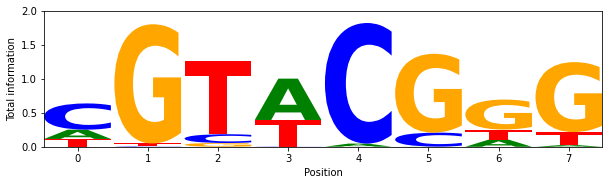

In [63]:
draw_motif(M)    

In [64]:
draw_sequences(sequences[:20], positions)

# Expectation-Maximization

## Calculate log-likelihood of data

In [65]:
def log_likelihood(
    sequences,
    motif
):
    """
    Calculate the log-likehood of the sequences given the motif, 
    integrating over all positions.
    """
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    C = (1.0 / max_position) * (1.0/4)**(sequence_length - motif_length)
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        for i in range(max_position):
            q = C
            for k in range(motif_length):
                q *= motif[k, sequences[n, i + k]] 
            p += q
        ll += np.log(p)
                        
    return ll
        

## Expectation step

In [66]:
def expectation_step(
    sequences,
    motif
):
    # Initialize
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                likelihood *= motif[k, sequences[n, i + k]]
            positions_posterior[n, i] = likelihood
            
        # Normalize
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior
    

## Maximization step

In [67]:
def maximization_step(
    sequences,
    positions_posterior,
):
    # Initialize
    max_position = sequence_length - motif_length + 1
    motif_estimate = np.zeros((motif_length, 4), dtype=float)   
    
    # Add dirichlet prior
    motif_estimate += alpha
    
    # Build the estimate
    for k in range(motif_length):
        for n in range(num_sequences):
            for i in range(max_position):
                # Which nucleotide is in the k-th position of the i-th k-mer 
                # in the n-th sequence?
                j = sequences[n, i+k]
                
                # Update the respective estimate
                motif_estimate[k, j] += positions_posterior[n, i]
                
        # Normalize
        motif_estimate[k, :] /= motif_estimate[k, :].sum()
                
    return motif_estimate
        
    

## EM algorithm

In [68]:
def expectation_maximization(
    sequences,
    n_iterations,
    print_every=None,
):
    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posterior_matrices = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood(sequences, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step(sequences, est_motif)
        positions_posterior_matrices.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior)
    
    return est_motif, lls, positions_posterior_matrices

## Run it!

In [166]:
est_motif, lls, positions_posterior_matrices = expectation_maximization(sequences, 100, print_every=10)

Iteration 0: LL = -12471.440384410167
Iteration 10: LL = -12098.131625021537
Iteration 20: LL = -12098.131624948754
Iteration 30: LL = -12098.131624948754
Iteration 40: LL = -12098.131624948754
Iteration 50: LL = -12098.131624948754
Iteration 60: LL = -12098.131624948754
Iteration 70: LL = -12098.131624948754
Iteration 80: LL = -12098.131624948754
Iteration 90: LL = -12098.131624948754


# MCMC

In [136]:
def log_likelihood_with_positions(
    sequences,
    positions,
    motif,
):
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        i = positions[n]
        q = 1
        for k in range(motif_length):
            q *= motif[k, sequences[n, i + k]] 
        p += q
        ll += np.log(p)
                        
    return ll

In [137]:
def gibbs_sample_position(
    sequences,
    est_motif,
    rng,
):
    max_position = sequence_length - motif_length + 1

    # Draw new positions
    positions_posterior = expectation_step(sequences, est_motif)
    positions = np.zeros(len(sequences), dtype=int)
    for n in range(num_sequences):
        positions[n] = rng.choice(max_position, p=positions_posterior[n])
        
    return positions


In [140]:
def calculate_dirichlet_parameters(
    alpha,
    sequences,
    est_positions,
    motif_length,
):
    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichelt parameters
    dirichlet_parameters = np.ones((motif_length, 4), dtype=float) * alpha    
    for k in range(motif_length):
        for n in range(num_sequences):
            c = sequences[n, est_positions[n] + k]
            dirichlet_parameters[k,c] += 1            
    
    return dirichlet_parameters
    

In [139]:
def gibbs_sample_motif(
    alpha,
    sequences,
    est_positions,
    motif_length,
    rng,
):
    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichelt parameters
    dirichlet_parameters = calculate_dirichlet_parameters(
        alpha,
        sequences,
        est_positions,
        motif_length,
    )            
    
    # Draw new motif from this distribution
    est_motif = np.zeros((motif_length, 4), dtype=float)
    for k in range(motif_length):
        est_motif[k, :] = rng.dirichlet(dirichlet_parameters[k])
        
    return est_motif
    

In [145]:
def metropolis_hastings_step(
    sequences,
    est_positions,
    est_motif,    
    current_ll,
    max_position,
    rng,
):
    # Make new state
    if rng.random() < 0.5:
        # abcdefgh -> habcdefg
        new_motif = np.roll(est_motif, 1, axis=0)
        new_positions = (est_positions - 1) % max_position
    else:
        # abcdefgh -> bcdefgha
        new_motif = np.roll(est_motif, -1, axis=0)
        new_positions = (est_positions + 1) % max_position
        
    # Calculate likelihood of new state
    new_ll = log_likelihood_with_positions(sequences, new_positions, new_motif)
    
    # Acceptance ratio
    acceptance_ratio = min(1.0, np.exp(new_ll - current_ll))
    
    # Accept if needed
    if rng.random() < acceptance_ratio:
        return new_motif, new_positions, True
    else:
        return est_motif, est_positions, False
        

In [148]:
def mcmc_sampling(
    sequences,
    motif_length,
    alpha,
    n_iterations,
    with_shifts=True,
    print_every=None,
):
    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Initialize positions
    max_position = sequence_length - motif_length + 1
    est_positions = rng.integers(max_position, size=num_sequences)
        
    # MCMC iterations
    lls = []
    states = []
    all_shifted = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        states.append([est_motif, est_positions])
        ll = log_likelihood_with_positions(sequences, est_positions, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
            
        # Draw new positions
        est_positions = gibbs_sample_position(sequences, est_motif, rng)
        
        # Draw new motif
        est_motif = gibbs_sample_motif(
            alpha,
            sequences,
            est_positions,
            motif_length,
            rng,
        )
        
        # Possible shift
        if with_shifts:
            est_motif, est_positions, shifted = metropolis_hastings_step(
                sequences,
                est_positions,
                est_motif,    
                ll,
                max_position,
                rng,
            )
            all_shifted.append(shifted)
        
    return lls, all_shifted, states
    

    

## Run it!

In [151]:
lls, all_shifted, states = mcmc_sampling(
    sequences,
    K,
    alpha,
    1000,
    with_shifts=True,
    print_every=100,
)

Iteration 0: LL = -1082.6698011258447
Iteration 100: LL = -142.19557900349406
Iteration 200: LL = -150.87513469081338
Iteration 300: LL = -139.53381366793988
Iteration 400: LL = -140.58182575908856
Iteration 500: LL = -138.40376602322175
Iteration 600: LL = -139.3940582918625
Iteration 700: LL = -140.1248579561142
Iteration 800: LL = -146.59923418650172
Iteration 900: LL = -137.5404761133705


# Real data?

In [271]:
# pip install biopython
from Bio import SeqIO

fasta_sequences = SeqIO.parse(open("intestine.fa"),'fasta')

sequences = []
for fasta in fasta_sequences:
    s = str(fasta.seq)
    table = s.maketrans('ACGT','0123')
    s = s.translate(table)
    s = np.array(list(s)).astype(int)
    sequences.append(s)

sequences = np.array(sequences)
print(sequences.shape)

(331, 500)


### Filter only for sequences with forward sequence

In [272]:
indices = [n for n, S in enumerate(sequences) if np.any([np.all(S[i:i+6]==np.array([1,3,3,0,3,1])) for i in range(500-6)])]
sequences = sequences[indices]
num_sequences, sequence_length = sequences.shape

# filter_run_length = 4

# runs = 0
# for i, S in enumerate(sequences):
#     for n in range(len(S) - filter_run_length):
#         if np.all(sequences[i, n:n+filter_run_length] == sequences[i, n]):
#             sequences[i, n:n+filter_run_length] = rng.choice(4, size=filter_run_length, p=[0.3, 0.2, 0.2, 0.3])
#             runs += 1
            
# print(runs)


In [273]:
background_model = pd.value_counts(np.ravel(sequences), normalize=True)[np.arange(4)].values
print(background_model)

[0.33419512 0.1624878  0.15556098 0.3477561 ]


In [274]:
background_firstorder_model = pd.crosstab(np.ravel(sequences)[:-1], np.ravel(sequences)[1:], normalize=0).values
print(background_firstorder_model)

[[0.42475551 0.14683988 0.13107576 0.29732886]
 [0.37766437 0.16301411 0.14380066 0.31552086]
 [0.347867   0.17095358 0.16656211 0.31461731]
 [0.22078833 0.17337635 0.1796886  0.42614672]]


In [270]:
def log_likelihood_with_background(sequences, motif, background):
    """
    Calculate the log-likehood of the sequences given the motif, 
    integrating over all positions.
    """
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1    
    
    # Per sequence, add the log-likelihood
    
    for n in range(num_sequences):        
        # This has to be done in log-space
        log_constant_part = -np.log(max_position) + np.sum(np.log(background_model[sequences[n]]))
        
        pseq = 0.0
        for i in range(max_position):            
            part = 1.0
            for k in range(motif_length):
                part *= (motif[k, sequences[n, i + k]] / background_model[sequences[n, i + k]])
            pseq += part
            
        ll += log_constant_part + np.log(pseq)
                        
    return ll

def log_likelihood_with_background_pairs(sequences, motif, background_pairs):
    """
    Calculate the log-likehood of the sequences given the motif, 
    integrating over all positions.
    """
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1    
    
    # Per sequence, add the log-likelihood
    
    for n in range(num_sequences):        
        # This has to be done in log-space
        log_constant_part = -np.log(max_position) + np.sum(np.log(
            background_pairs[sequences[n,:-1], sequences[n,1:]]
        ))
        
        pseq = 0.0
        for i in range(max_position):            
            part = 1.0
            for k in range(motif_length):
                part *= motif[k, sequences[n, i + k]] 
                if k != motif_length-1:
                    part /= background_pairs[sequences[n, i + k], sequences[n, i + k + 1]]
            pseq += part
            
        ll += log_constant_part + np.log(pseq)
                        
    return ll
        

In [277]:
def expectation_step_with_background(sequences, motif, background):
    """
    Calculate the posterior probabilities of the motif being at each position in each sequence
    """
    # Initialize
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                # update the joint likelihood for position k in the motif
                likelihood *= motif[k, sequences[n, i + k]] / background[sequences[n, i + k]]
            positions_posterior[n, i] = likelihood
            
        # Normalize the posteriors for sequence n to sum to 1
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior

def expectation_step_with_background_pairs(sequences, motif, background_pairs):
    """
    Calculate the posterior probabilities of the motif being at each position in each sequence
    """
    # Initialize
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                # update the joint likelihood for position k in the motif
                likelihood *= motif[k, sequences[n, i + k]] 
                if k != motif_length-1:
                    likelihood /= background_pairs[sequences[n, i + k], sequences[n, i + k + 1]]
                    
            positions_posterior[n, i] = likelihood
            
        # Normalize the posteriors for sequence n to sum to 1
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior

In [317]:
def expectation_maximization_with_background(sequences, n_iterations, background, print_every=None):
    """
    search for a maximum likelihood motif estimate by alternating expectation_ and maximisation_ steps
    return the estimated motif, and the log likelihoods, position distributions and motifs at each step
    """
    # Initialize the motif estimate randomly
    est_motif = np.random.default_rng().random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posteriors = []
    motifs = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood_with_background(sequences, est_motif, background)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step_with_background(sequences, est_motif, background)
        positions_posteriors.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior)
        motifs.append(est_motif)
    
    return est_motif, lls, positions_posteriors, motifs

def expectation_maximization_with_background_pairs(sequences, n_iterations, background_pairs, print_every=None, est_motif=None):
    """
    search for a maximum likelihood motif estimate by alternating expectation_ and maximisation_ steps
    return the estimated motif, and the log likelihoods, position distributions and motifs at each step
    """
    # Initialize the motif estimate randomly
    if est_motif is None:
        est_motif = np.random.default_rng().random(size=(motif_length, 4))
        est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posteriors = []
    motifs = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood_with_background_pairs(sequences, est_motif, background_pairs)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step_with_background_pairs(sequences, est_motif, background_pairs)
        positions_posteriors.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior)
        motifs.append(est_motif)
    
    return est_motif, lls, positions_posteriors, motifs

In [279]:
def plot_results(iters,est_motif,lls,posteriors,motifs):
    print (f"LL with true motif {log_likelihood(sequences,M)}")
    print (f"LL with final estimated motif {log_likelihood(sequences,est_motif)}")
    
    # plot the true and final estimated motifs
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    draw_motif(M,ax=axs[0])
    axs[0].set_title("True motif")
    draw_motif(est_motif,ax=axs[1])
    axs[1].set_title("Final estimated motif")
   
    if lls is not None:
        # plot the log likelihoods
        plt.figure()
        plt.plot(lls)
        plt.xlabel("# of iteration")
        plt.ylabel("log likelihood")
    
    if len(iters) > 0 and posteriors is not None:
        # plot heatmaps of the motif locations at given iterations
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 8))
        for ax, n_iter in zip(axs, iters):
            sns.heatmap(posteriors[n_iter][:,:], ax=ax, vmin=0, vmax=1);
            ax.set_title(f"Iteration # {n_iter}")
            ax.set_ylabel("Sequence #")
            ax.set_xlabel("Position")
    
    if len(iters) > 0 and motifs is not None:
       # and below them the motifs
        fig, axs = plt.subplots(1, len(iters), figsize=(20, 2))
        for ax, n_iter in zip(axs, iters):
            draw_motif(motifs[n_iter],ax=ax)

In [237]:
est_motif, lls, positions_posteriors, motifs = \
    expectation_maximization_with_background(sequences, 200, np.array([0.25, 0.25, 0.25, 0.25]), 10)


Iteration 0: LL = -27874.97074094181
Iteration 10: LL = -27858.591805068834
Iteration 20: LL = -27848.578125281394
Iteration 30: LL = -27847.51279303286
Iteration 40: LL = -27847.385048342112
Iteration 50: LL = -27847.375499814636
Iteration 60: LL = -27847.37677359451
Iteration 70: LL = -27847.378118419303
Iteration 80: LL = -27847.378797869922
Iteration 90: LL = -27847.37908760868
Iteration 100: LL = -27847.379202459466
Iteration 110: LL = -27847.37924626387
Iteration 120: LL = -27847.37926260139
Iteration 130: LL = -27847.379268612083
Iteration 140: LL = -27847.379270804584
Iteration 150: LL = -27847.379271599955
Iteration 160: LL = -27847.379271887457
Iteration 170: LL = -27847.37927199115
Iteration 180: LL = -27847.379272028495
Iteration 190: LL = -27847.37927204193


LL with true motif -28529.775352295226
LL with final estimated motif -28339.464512994753


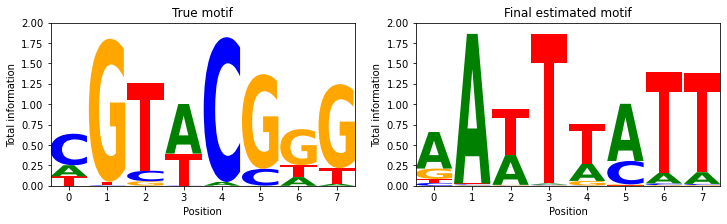

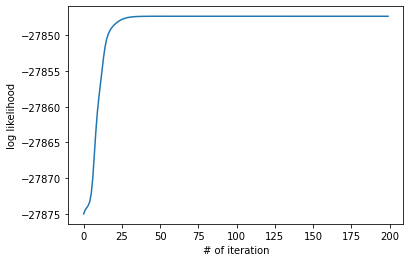

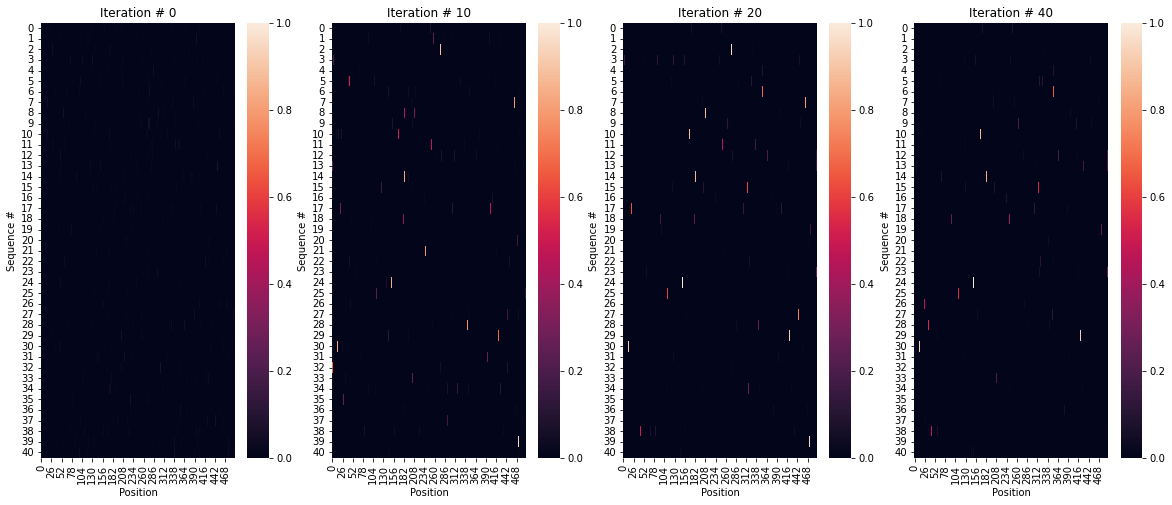

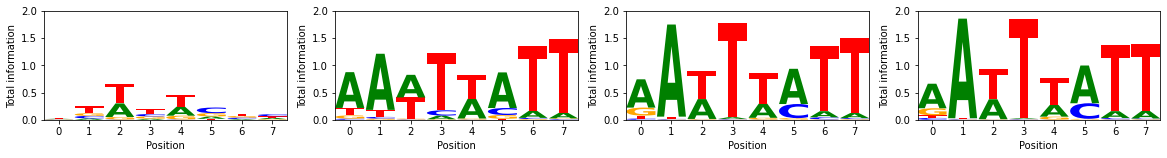

In [238]:
plot_results([0,10,20,40], est_motif, lls, positions_posteriors, motifs)


In [295]:
intestine_motif

array([[1.76754668e-01, 2.34063104e-01, 1.20090148e-01, 4.69092080e-01],
       [8.24211204e-02, 1.98647778e-01, 1.35544108e-01, 5.83386993e-01],
       [2.89761751e-03, 9.96780425e-01, 3.21957502e-04, 0.00000000e+00],
       [3.54153252e-03, 1.12685126e-02, 5.15132003e-03, 9.80038635e-01],
       [9.65872505e-04, 0.00000000e+00, 0.00000000e+00, 9.99034127e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.43915003e-04, 3.21957502e-03, 0.00000000e+00, 9.96136510e-01],
       [1.12685126e-02, 9.87765615e-01, 3.21957502e-04, 6.43915003e-04],
       [7.12491951e-01, 1.64198326e-02, 9.56213780e-02, 1.75466838e-01],
       [2.75595621e-01, 2.24726336e-01, 2.91693496e-01, 2.07984546e-01]])

In [300]:
noisy_intestine_motif = intestine_motif.copy()
noisy_intestine_motif += rng.normal(scale=0.1)
noisy_intestine_motif /= noisy_intestine_motif.sum(axis=1)[:, np.newaxis]

In [302]:
est_motif, lls, positions_posteriors, motifs = \
    expectation_maximization_with_background_pairs(sequences, 200, background_firstorder_model, 10, est_motif=None)


Iteration 0: LL = -26652.6701446915
Iteration 10: LL = -26634.930926209825
Iteration 20: LL = -26626.557170540986
Iteration 30: LL = -26623.973157770986
Iteration 40: LL = -26623.532973637455
Iteration 50: LL = -26623.41347595826
Iteration 60: LL = -26623.368771833375
Iteration 70: LL = -26623.352295711567
Iteration 80: LL = -26623.346102378357


KeyboardInterrupt: 

LL with true motif -28561.681072706244
LL with final estimated motif -28314.864156631367


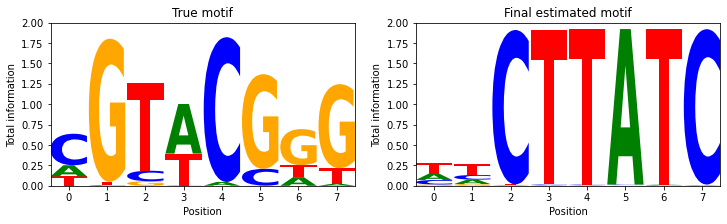

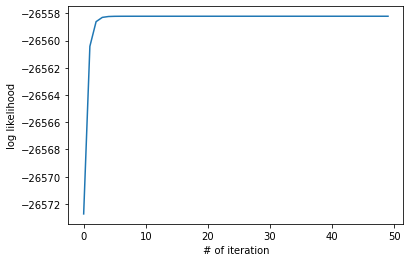

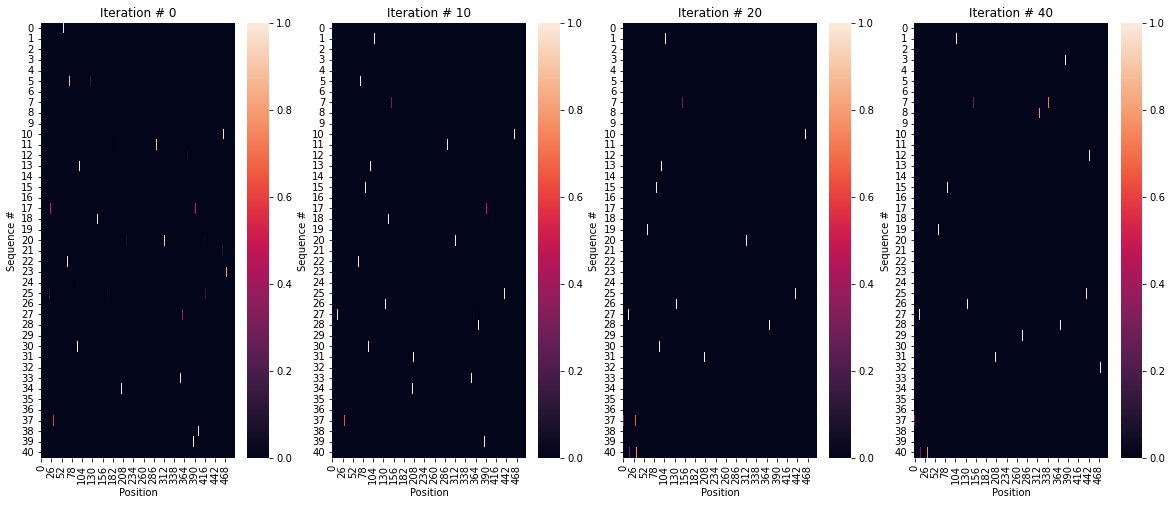

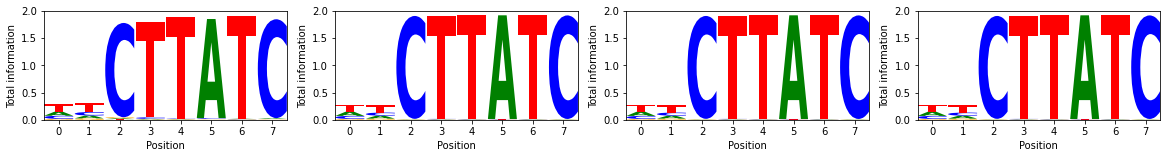

In [299]:
plot_results([0,10,20,40], est_motif, lls, positions_posteriors, motifs)


In [288]:
log_likelihood_with_background_pairs(sequences, intestine_motif, background_firstorder_model)

-26562.780090764005

In [290]:
log_likelihood_with_background_pairs(sequences, est_motif, background_firstorder_model)

-26617.497612017298

In [303]:
import joblib

In [313]:
all_res = joblib.Parallel(n_jobs=-1, verbose=50)(
    joblib.delayed(expectation_maximization_with_background_pairs)(sequences, 200, background_firstorder_model, 10, est_motif=None)
    for i in range(20))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:  1.3min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  1.3min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.3min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:  1.3min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:  1.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  1.3min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  2.6min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapse

In [323]:
np.sort([R[1][-1] for R in all_res])

array([-26628.24927743, -26624.8120791 , -26624.66341714, -26624.49836535,
       -26623.94575035, -26623.67960811, -26623.56261761, -26623.56261628,
       -26621.41232483, -26621.23579775, -26620.54467455, -26620.54466986,
       -26620.23266524, -26619.47310058, -26618.87043087, -26618.85794921,
       -26617.61385122, -26617.03861533, -26558.20689716, -26558.20689716])

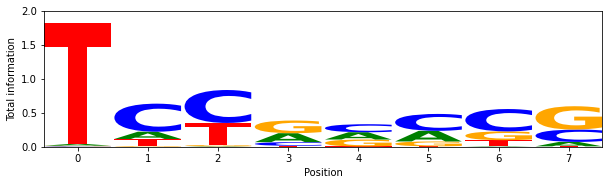

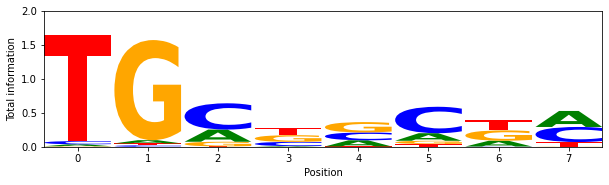

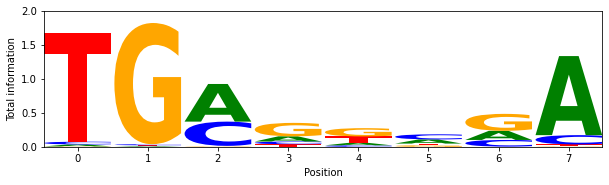

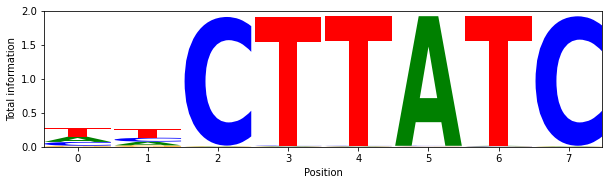

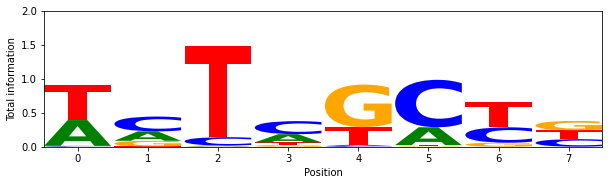

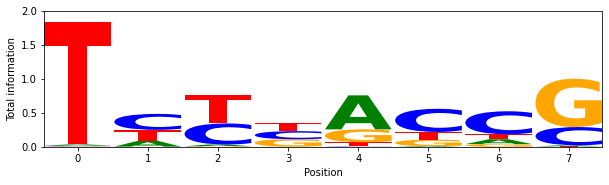

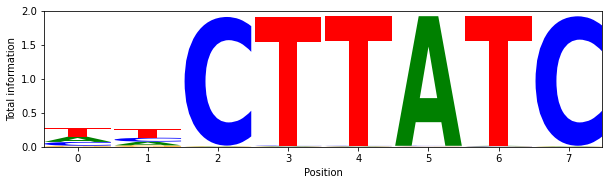

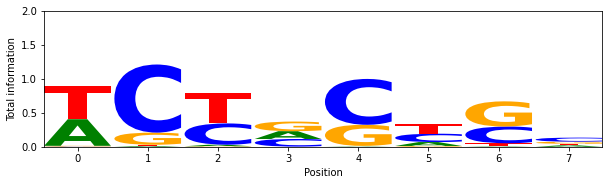

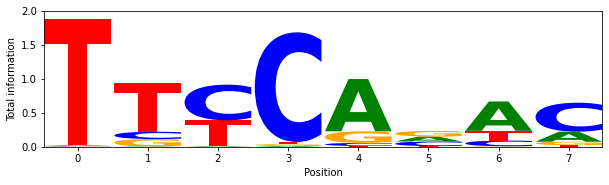

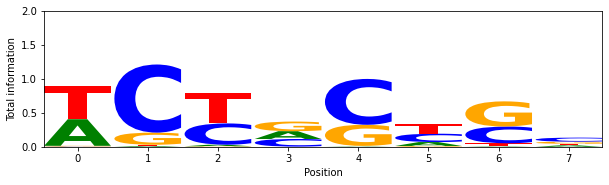

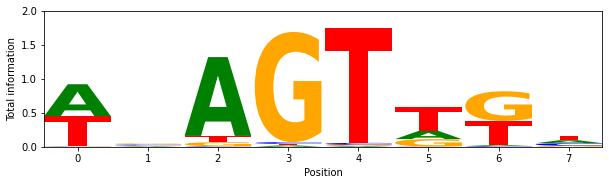

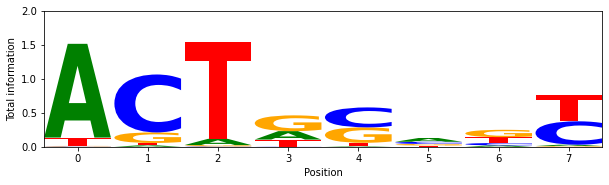

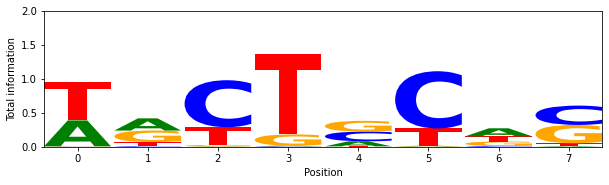

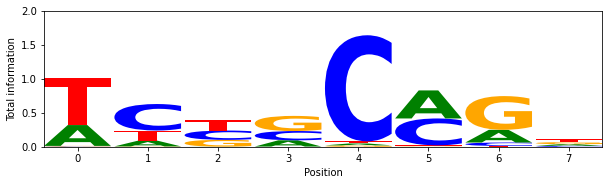

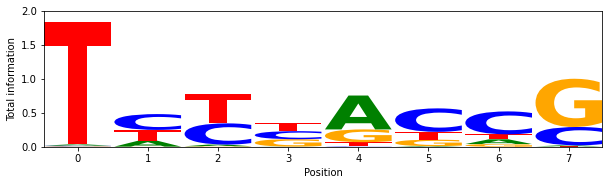

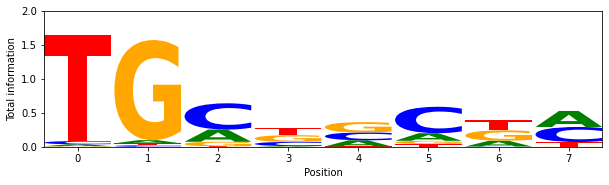

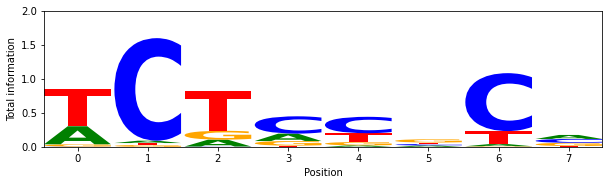

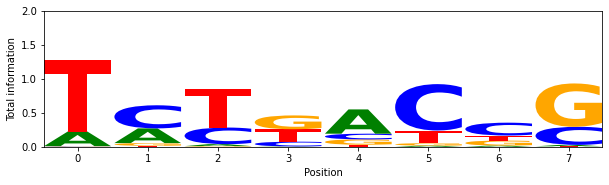

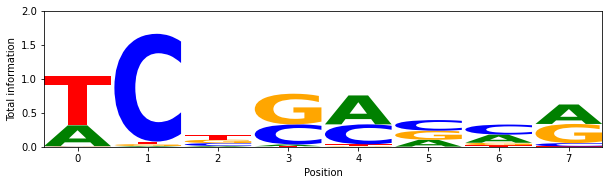

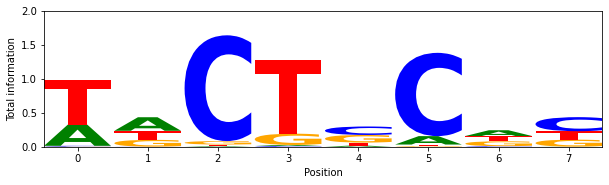

In [314]:
for R in all_res:
    draw_motif(R[0])

In [334]:
all_res_single = joblib.Parallel(n_jobs=-1, verbose=50)(
    joblib.delayed(expectation_maximization_with_background)(sequences, 100, background_model, 10)
    for i in range(50))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

/Users/regevschweiger/opt/anaconda3/lib/python3.9/site-packages/logomaker/src/Logo.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=self.figsize)


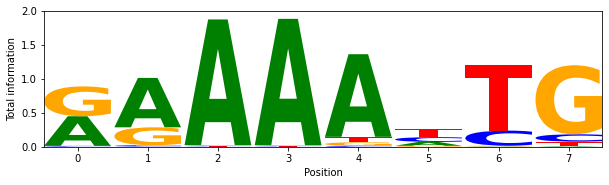

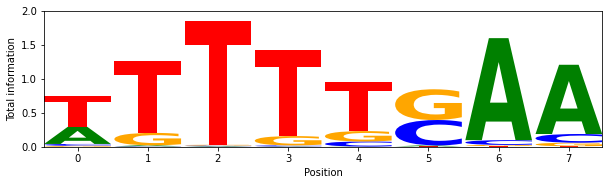

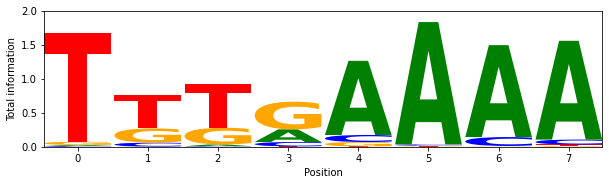

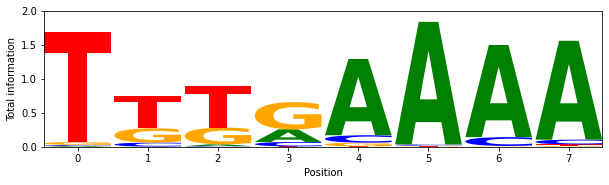

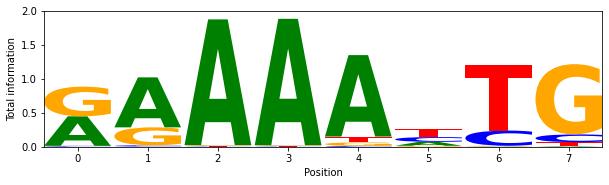

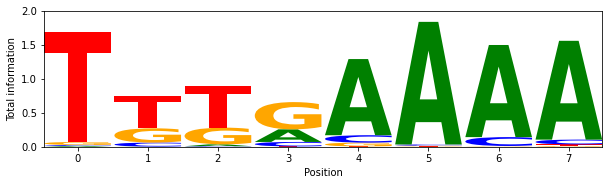

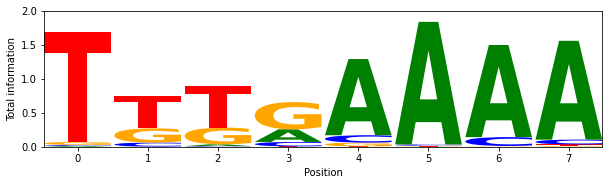

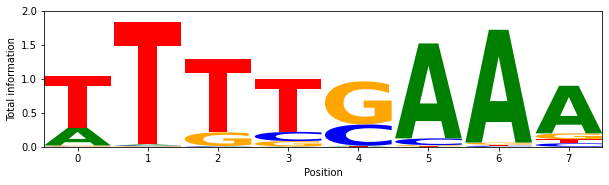

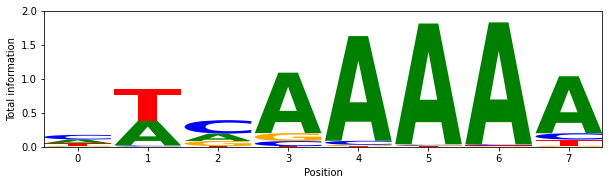

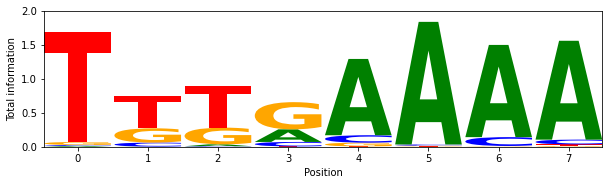

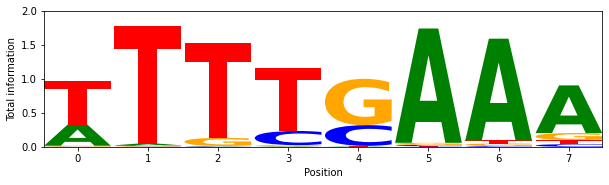

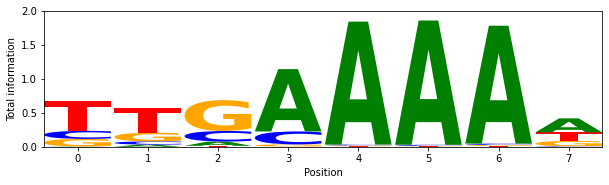

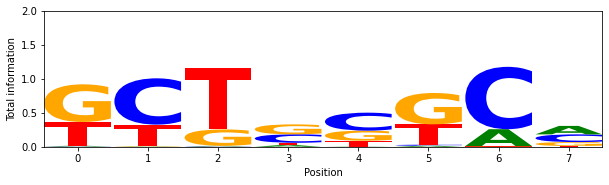

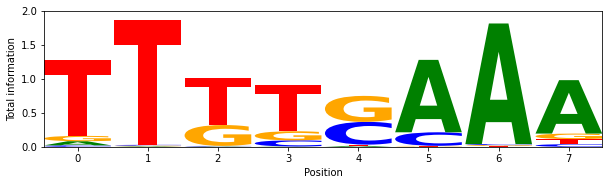

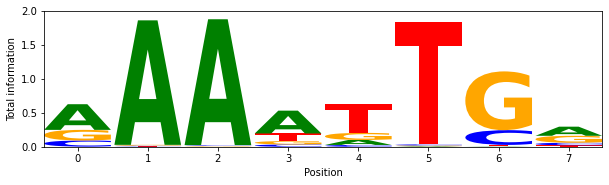

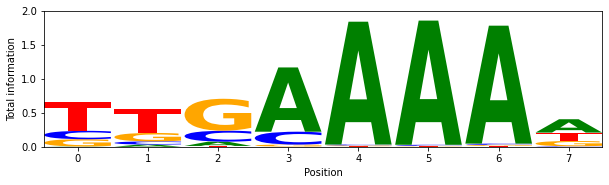

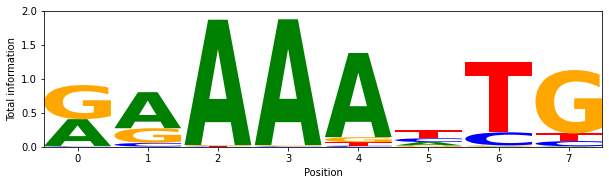

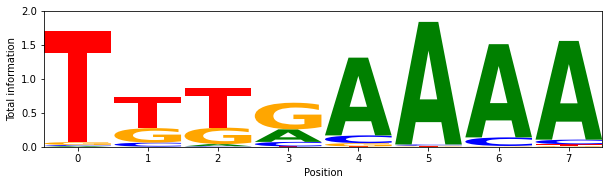

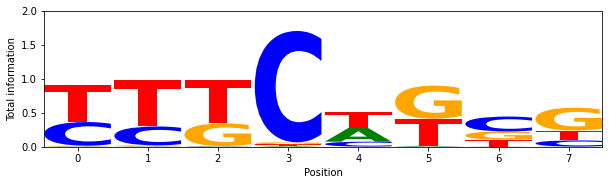

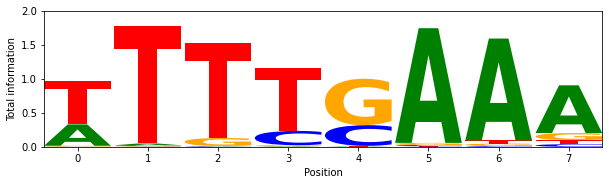

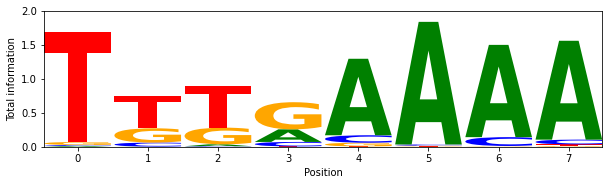

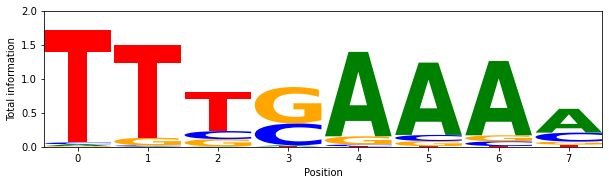

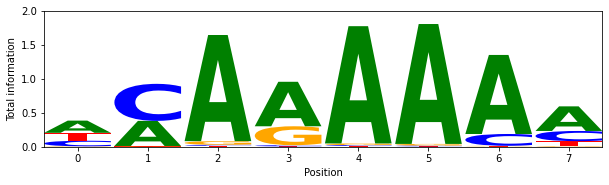

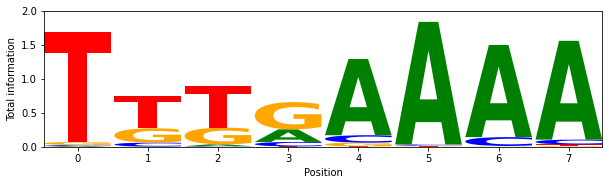

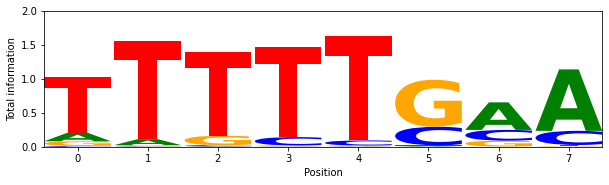

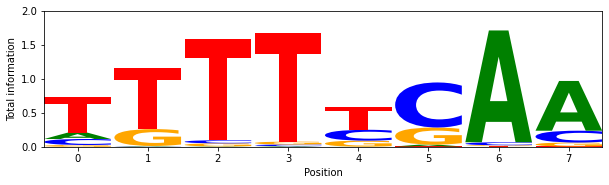

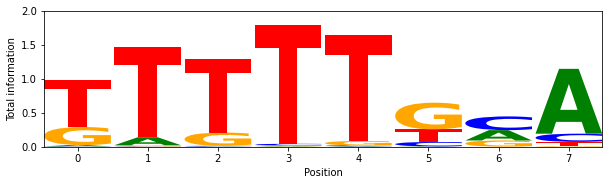

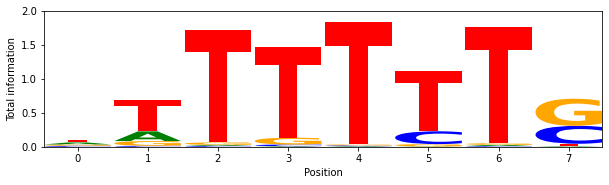

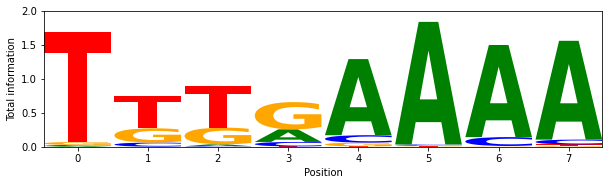

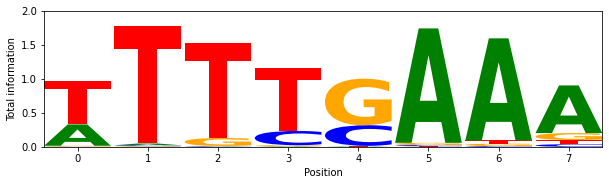

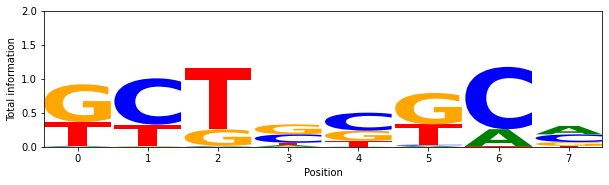

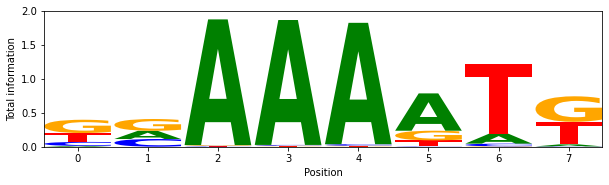

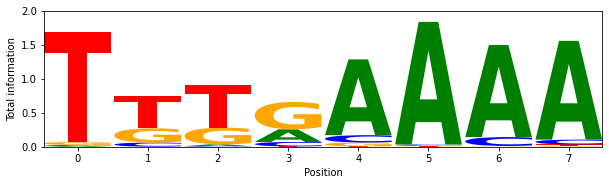

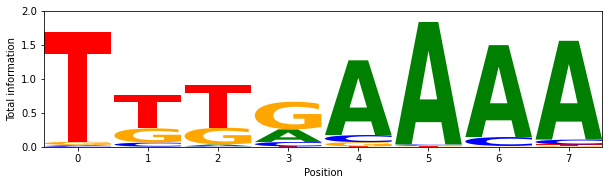

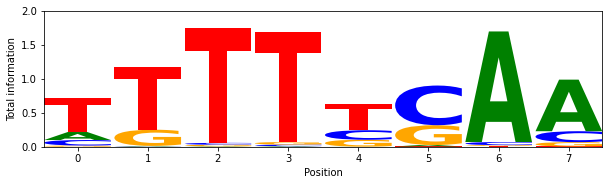

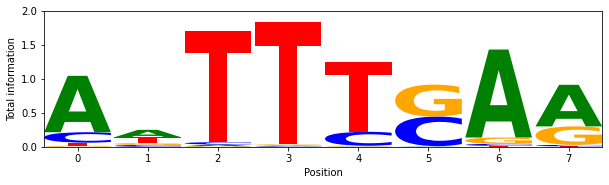

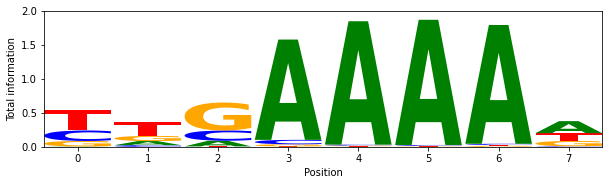

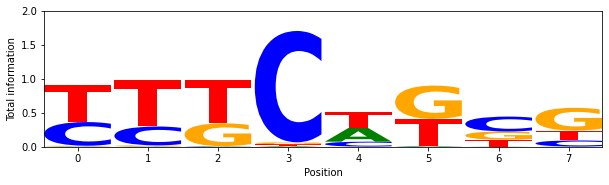

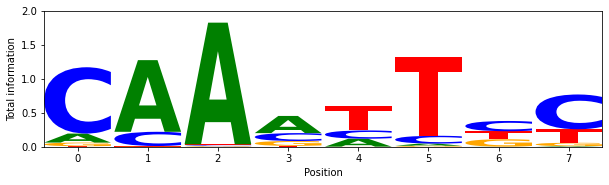

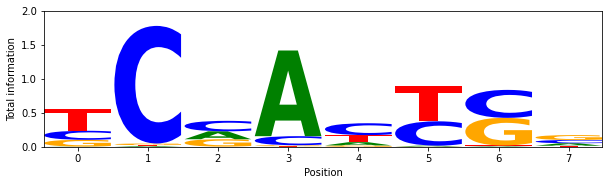

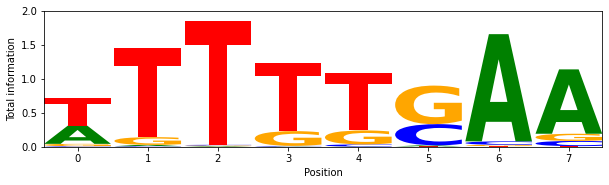

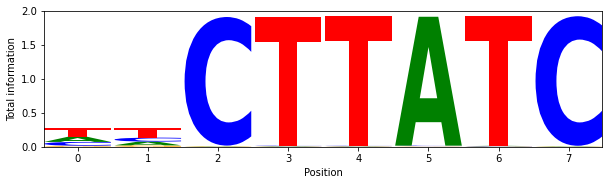

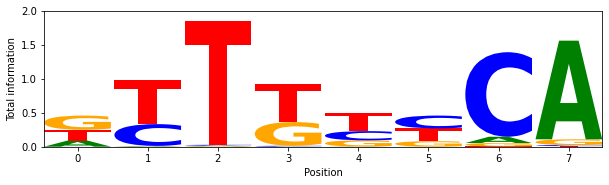

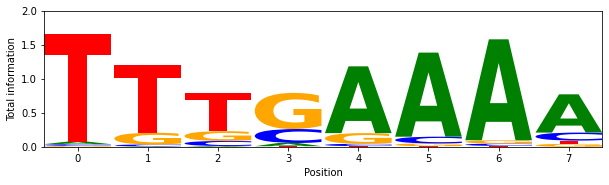

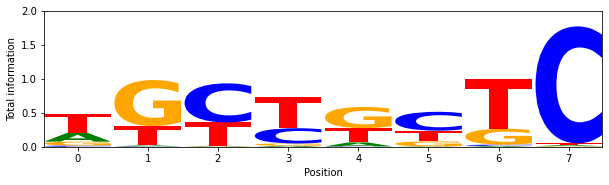

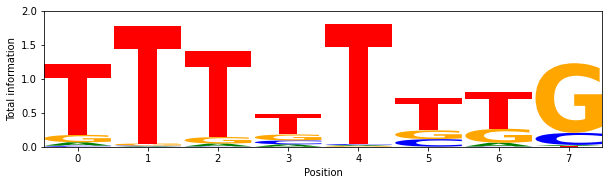

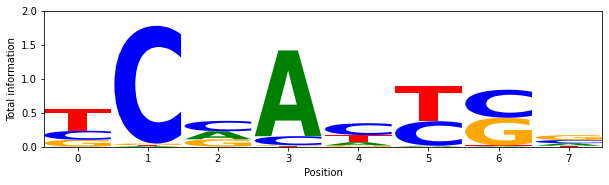

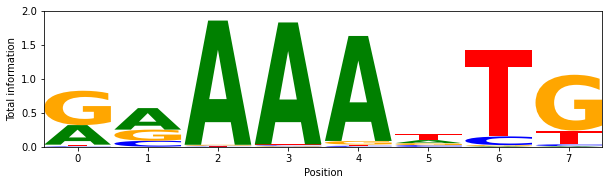

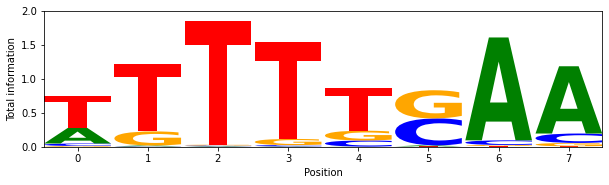

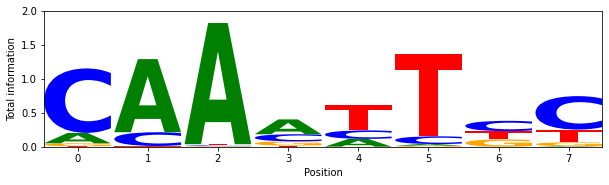

Iteration 0: LL = -27024.516667349366
Iteration 10: LL = -27013.395496989102
Iteration 20: LL = -26994.255913932255
Iteration 30: LL = -26984.55795898279
Iteration 40: LL = -26983.67974045569
Iteration 0: LL = -27028.56016397957
Iteration 10: LL = -27002.56462376192
Iteration 20: LL = -26991.175026205485
Iteration 30: LL = -26989.55329302269
Iteration 40: LL = -26988.005907180966
Iteration 0: LL = -27025.284017648788
Iteration 10: LL = -26997.663156906812
Iteration 20: LL = -26993.14873426588
Iteration 30: LL = -26991.97859367363
Iteration 40: LL = -26991.36024238646
Iteration 0: LL = -27019.196843776215
Iteration 10: LL = -26994.60924753985
Iteration 20: LL = -26986.36878480768
Iteration 30: LL = -26985.298595974517
Iteration 40: LL = -26984.287664495143
Iteration 0: LL = -27028.418382806616
Iteration 10: LL = -27006.799321212286
Iteration 20: LL = -26985.298947587216
Iteration 30: LL = -26978.601500404584
Iteration 40: LL = -26975.359965996806
Iteration 0: LL = -27023.902226814156
It

Iteration 0: LL = -27024.219563099294
Iteration 10: LL = -26998.33398228151
Iteration 20: LL = -26994.957975510333
Iteration 30: LL = -26993.988171727007
Iteration 40: LL = -26993.910753337528
Iteration 0: LL = -27023.609434892835
Iteration 10: LL = -27007.40739771454
Iteration 20: LL = -26998.12976410603
Iteration 30: LL = -26990.6011268457
Iteration 40: LL = -26989.132435427444
Iteration 0: LL = -27027.53500521828
Iteration 10: LL = -27004.89820147887
Iteration 20: LL = -26999.925302596774
Iteration 30: LL = -26997.73555203768
Iteration 40: LL = -26996.05396361603
Iteration 0: LL = -27027.39199192924
Iteration 10: LL = -27008.207482295526
Iteration 20: LL = -27004.095752434183
Iteration 30: LL = -27001.053396268286
Iteration 40: LL = -26993.300851088585
Iteration 0: LL = -27025.125905201803
Iteration 10: LL = -26987.107203428382
Iteration 20: LL = -26979.608388872402
Iteration 30: LL = -26977.169653477566
Iteration 40: LL = -26975.35396720384
Iteration 0: LL = -27021.67581159271
Iter

Iteration 0: LL = -27025.61949732226
Iteration 10: LL = -27012.92972316012
Iteration 20: LL = -26987.188758249562
Iteration 30: LL = -26983.182984294977
Iteration 40: LL = -26981.941905094347
Iteration 0: LL = -27022.614793648107
Iteration 10: LL = -27001.20454409069
Iteration 20: LL = -26993.062937351384
Iteration 30: LL = -26992.115384029254
Iteration 40: LL = -26992.002311130498
Iteration 0: LL = -27023.91922690285
Iteration 10: LL = -27006.833987099064
Iteration 20: LL = -26996.462362569055
Iteration 30: LL = -26994.11447665386
Iteration 40: LL = -26992.549435375935
Iteration 0: LL = -27025.53227440394
Iteration 10: LL = -26997.841133031
Iteration 20: LL = -26988.775918264808
Iteration 30: LL = -26983.941257308557
Iteration 40: LL = -26980.155136476307
Iteration 0: LL = -27026.190184838983
Iteration 10: LL = -27000.466643455653
Iteration 20: LL = -26991.140685725913
Iteration 30: LL = -26990.187938575098
Iteration 40: LL = -26989.618366925686
Iteration 0: LL = -27024.100979383828
I

Iteration 0: LL = -27023.164414697247
Iteration 10: LL = -26999.367475410898
Iteration 20: LL = -26985.885006896355
Iteration 30: LL = -26982.313267474212
Iteration 40: LL = -26980.957872380888
Iteration 0: LL = -27026.076431080455
Iteration 10: LL = -27013.861215093955
Iteration 20: LL = -27001.589897601483
Iteration 30: LL = -26996.512539303945
Iteration 40: LL = -26995.955432050778
Iteration 0: LL = -27018.824226938326
Iteration 10: LL = -27000.69615773479
Iteration 20: LL = -26992.584891602477
Iteration 30: LL = -26988.299371133693
Iteration 40: LL = -26983.708418178507
Iteration 0: LL = -27028.57099177141
Iteration 10: LL = -26999.59128055499
Iteration 20: LL = -26992.7769411081
Iteration 30: LL = -26988.261359842087
Iteration 40: LL = -26986.38108999617
Iteration 0: LL = -27026.415129636025
Iteration 10: LL = -26992.96395557547
Iteration 20: LL = -26986.65150248372
Iteration 30: LL = -26984.24232214686
Iteration 40: LL = -26983.58819586291
Iteration 0: LL = -27025.40866601725
Ite

In [335]:
for R in all_res_single:
    draw_motif(R[0])

In [327]:
all_res_single_uniform = joblib.Parallel(n_jobs=-1, verbose=50)(
    joblib.delayed(expectation_maximization_with_background)(sequences, 200, np.array([0.25, 0.25, 0.25, 0.25]), 10)
    for i in range(20))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:  1.2min remaining: 10.8min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  1.2min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  1.2min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:  1.2min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:  1.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  1.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  2.4min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapse

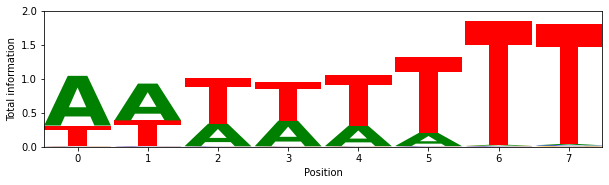

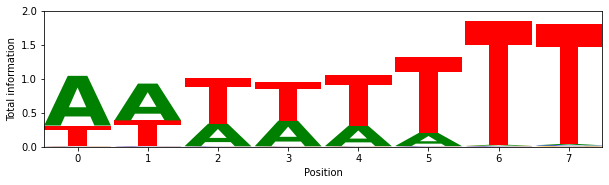

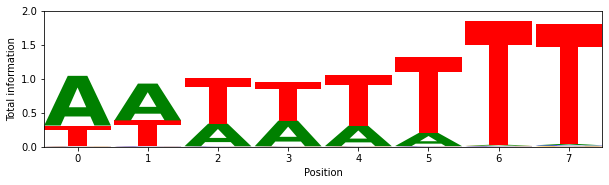

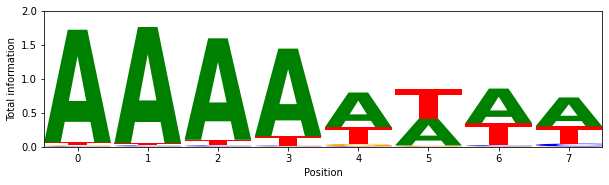

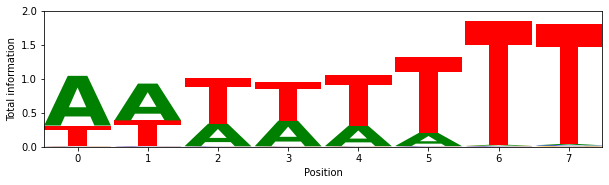

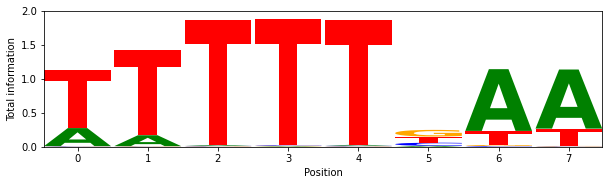

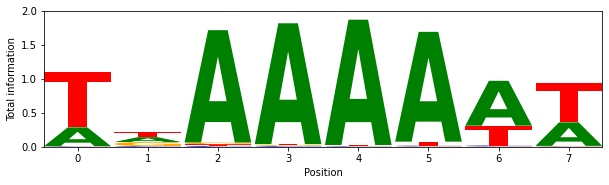

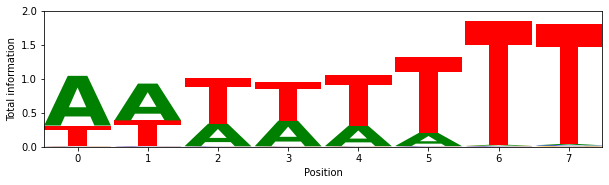

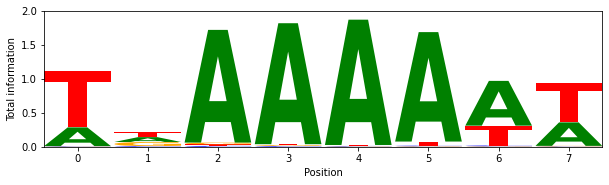

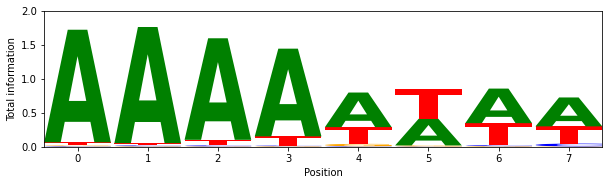

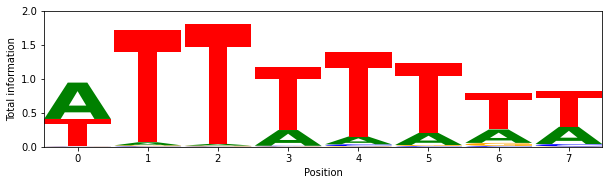

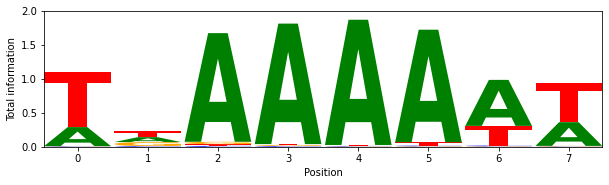

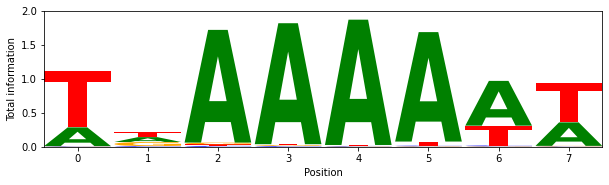

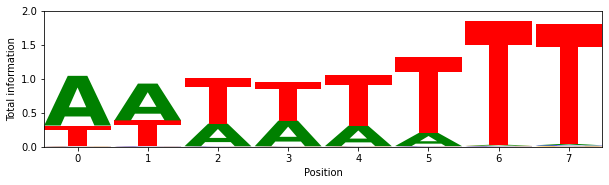

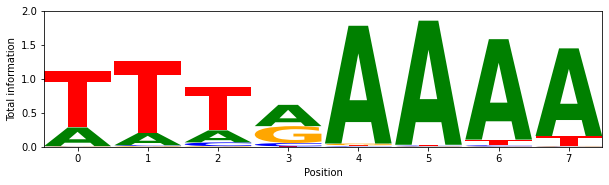

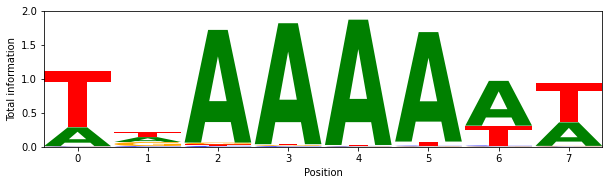

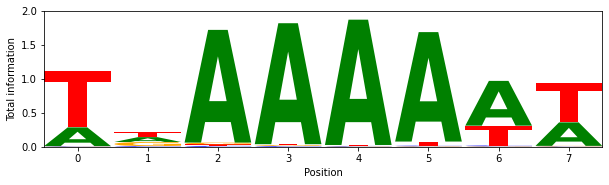

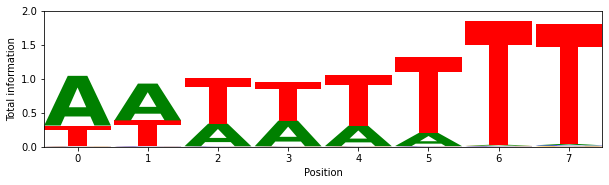

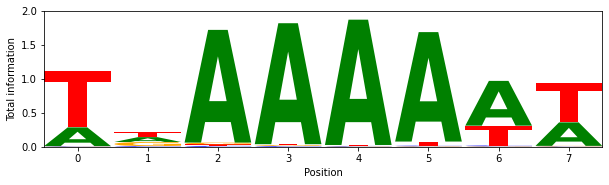

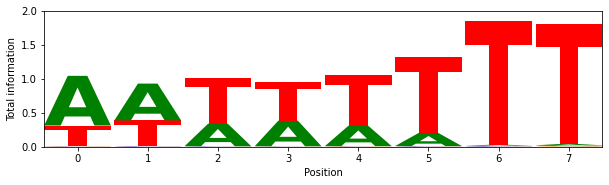

Iteration 0: LL = -26651.337679959204
Iteration 10: LL = -26625.164116395215
Iteration 20: LL = -26618.92275819162
Iteration 30: LL = -26617.996821254175
Iteration 40: LL = -26617.872291023705
Iteration 0: LL = -26651.827765825517
Iteration 10: LL = -26625.812903037422
Iteration 20: LL = -26620.942283455675
Iteration 30: LL = -26620.438306436437
Iteration 40: LL = -26620.310037909112
Iteration 50: LL = -26620.251153262834
Iteration 60: LL = -26620.171711117044
Iteration 70: LL = -26619.99696615112
Iteration 80: LL = -26619.740477787578
Iteration 90: LL = -26619.565674493108
Iteration 100: LL = -26619.49229301571
Iteration 110: LL = -26619.47042158001
Iteration 120: LL = -26619.46767901591
Iteration 130: LL = -26619.469266433982
Iteration 140: LL = -26619.470910974633
Iteration 150: LL = -26619.47195594429
Iteration 160: LL = -26619.472533743163
Iteration 170: LL = -26619.472835373206
Iteration 180: LL = -26619.472988556114
Iteration 190: LL = -26619.473065233225
Iteration 0: LL = -2665

Iteration 0: LL = -26650.717318212814
Iteration 10: LL = -26635.298979640993
Iteration 20: LL = -26631.195096024596
Iteration 30: LL = -26628.100602384682
Iteration 40: LL = -26627.340603075867
Iteration 50: LL = -26626.04455657247
Iteration 60: LL = -26622.72433793656
Iteration 70: LL = -26621.487046679376
Iteration 80: LL = -26621.27014967844
Iteration 90: LL = -26621.2426201348
Iteration 100: LL = -26621.2376573814
Iteration 110: LL = -26621.236379312963
Iteration 120: LL = -26621.235992054244
Iteration 130: LL = -26621.2358649603
Iteration 140: LL = -26621.235821430364
Iteration 150: LL = -26621.235806162564
Iteration 160: LL = -26621.235800733928
Iteration 170: LL = -26621.23579878819
Iteration 180: LL = -26621.235798087466
Iteration 190: LL = -26621.235797834393
Iteration 0: LL = -26652.38109132453
Iteration 10: LL = -26631.676851521315
Iteration 20: LL = -26629.245074747087
Iteration 30: LL = -26628.081685074198
Iteration 40: LL = -26626.426176278208
Iteration 50: LL = -26621.88

Iteration 0: LL = -26664.4853640758
Iteration 10: LL = -26637.658206563057
Iteration 20: LL = -26625.601503903268
Iteration 30: LL = -26618.77553301877
Iteration 40: LL = -26617.99057852221
Iteration 0: LL = -26660.455299515317
Iteration 10: LL = -26634.274016486295
Iteration 20: LL = -26622.781159500693
Iteration 30: LL = -26621.42069773351
Iteration 40: LL = -26621.03743078718
Iteration 50: LL = -26620.845087686826
Iteration 60: LL = -26620.66958316459
Iteration 70: LL = -26620.58898407288
Iteration 80: LL = -26620.562047981144
Iteration 90: LL = -26620.552156464335
Iteration 100: LL = -26620.54812103246
Iteration 110: LL = -26620.546345122868
Iteration 120: LL = -26620.54551435007
Iteration 130: LL = -26620.545106620837
Iteration 140: LL = -26620.544899408138
Iteration 150: LL = -26620.54479156393
Iteration 160: LL = -26620.54473455722
Iteration 170: LL = -26620.544704123946
Iteration 180: LL = -26620.544687775877
Iteration 190: LL = -26620.54467895996
Iteration 0: LL = -26665.75560

Iteration 0: LL = -26648.423470623275
Iteration 10: LL = -26622.32133914881
Iteration 20: LL = -26620.701038294294
Iteration 30: LL = -26619.9456119184
Iteration 40: LL = -26619.578732651098
Iteration 0: LL = -26663.716604189332
Iteration 10: LL = -26633.761117059486
Iteration 20: LL = -26630.118318363242
Iteration 30: LL = -26628.947993157548
Iteration 40: LL = -26627.19005013575
Iteration 50: LL = -26625.265734193563
Iteration 60: LL = -26624.797903914674
Iteration 70: LL = -26624.76395382655
Iteration 80: LL = -26624.77439305949
Iteration 90: LL = -26624.784496298496
Iteration 100: LL = -26624.79119077469
Iteration 110: LL = -26624.795678446048
Iteration 120: LL = -26624.798931804842
Iteration 130: LL = -26624.801478814312
Iteration 140: LL = -26624.80359088234
Iteration 150: LL = -26624.8054120727
Iteration 160: LL = -26624.80702437157
Iteration 170: LL = -26624.808478573294
Iteration 180: LL = -26624.8098088901
Iteration 190: LL = -26624.811040069617
Iteration 0: LL = -26655.14785

Iteration 0: LL = -26656.222548186037
Iteration 10: LL = -26629.648784835277
Iteration 20: LL = -26624.92487366918
Iteration 30: LL = -26623.114493140383
Iteration 40: LL = -26622.86460469789
Iteration 50: LL = -26622.85236849259
Iteration 60: LL = -26622.86040569282
Iteration 70: LL = -26622.864967172576
Iteration 80: LL = -26622.850375048318
Iteration 90: LL = -26622.77974466495
Iteration 100: LL = -26622.606648152312
Iteration 110: LL = -26622.312722336446
Iteration 120: LL = -26621.89012133037
Iteration 130: LL = -26621.614156453215
Iteration 140: LL = -26621.503127288717
Iteration 150: LL = -26621.45401489112
Iteration 160: LL = -26621.43081198599
Iteration 170: LL = -26621.420144400196
Iteration 180: LL = -26621.415362443102
Iteration 190: LL = -26621.41322575626
Iteration 0: LL = -26646.77214825792
Iteration 10: LL = -26622.71947926817
Iteration 20: LL = -26618.227906176602
Iteration 30: LL = -26617.465908176877
Iteration 40: LL = -26617.18222600145
Iteration 50: LL = -26617.081

In [328]:
for R in all_res_single_uniform:
    draw_motif(R[0])

# EM for real data (sorted out)

## Loading data

In [336]:
# pip install biopython
from Bio import SeqIO

fasta_sequences = SeqIO.parse(open("intestine.fa"),'fasta')

sequences = []
for fasta in fasta_sequences:
    s = str(fasta.seq)
    table = s.maketrans('ACGT','0123')
    s = s.translate(table)
    s = np.array(list(s)).astype(int)
    sequences.append(s)

sequences = np.array(sequences)
print(sequences.shape)

(331, 500)


### Filter only for sequences with forward sequence

In [337]:
indices = [n for n, S in enumerate(sequences) if np.any([np.all(S[i:i+6]==np.array([1,3,3,0,3,1])) for i in range(500-6)])]
sequences = sequences[indices]
num_sequences, sequence_length = sequences.shape


## Estimate background model

In [343]:
background_model = np.histogram(np.ravel(sequences), bins=np.arange(5), density=True)[0]
print(background_model)

[0.33419512 0.1624878  0.15556098 0.3477561 ]


## Versions of EM functions to deal with background

In [344]:
def log_likelihood_with_background(sequences, motif, background):
    """
    Calculate the log-likehood of the sequences given the motif, 
    integrating over all positions.
    """
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1    
    
    # Per sequence, add the log-likelihood
    
    for n in range(num_sequences):        
        # This has to be done in log-space
        log_constant_part = -np.log(max_position) + np.sum(np.log(background_model[sequences[n]]))
        
        pseq = 0.0
        for i in range(max_position):            
            part = 1.0
            for k in range(motif_length):
                part *= (motif[k, sequences[n, i + k]] / background_model[sequences[n, i + k]])
            pseq += part
            
        ll += log_constant_part + np.log(pseq)
                        
    return ll


In [345]:
def expectation_step_with_background(sequences, motif, background):
    """
    Calculate the posterior probabilities of the motif being at each position in each sequence
    """
    # Initialize
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                # update the joint likelihood for position k in the motif
                likelihood *= motif[k, sequences[n, i + k]] / background[sequences[n, i + k]]
            positions_posterior[n, i] = likelihood
            
        # Normalize the posteriors for sequence n to sum to 1
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior


In [346]:
def expectation_maximization_with_background(sequences, n_iterations, background, print_every=None):
    """
    search for a maximum likelihood motif estimate by alternating expectation_ and maximisation_ steps
    return the estimated motif, and the log likelihoods, position distributions and motifs at each step
    """
    # Initialize the motif estimate randomly
    est_motif = np.random.default_rng().random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posteriors = []
    motifs = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood_with_background(sequences, est_motif, background)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step_with_background(sequences, est_motif, background)
        positions_posteriors.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior)
        motifs.append(est_motif)
    
    return est_motif, lls, positions_posteriors, motifs


## Runnings many jobs in parallel

In [ ]:
import joblib

all_res_single = joblib.Parallel(n_jobs=-1, verbose=50)(
    joblib.delayed(expectation_maximization_with_background)(sequences, 100, background_model, 10)
        for i in range(50)
)


In [ ]:
for R in all_res_single:
    draw_motif(R[0])